In [5]:
import pandas as pd
import networkx as nx
import osmnx as ox
import config
import random
import math
import util
import testing.helpers.testing_helper as test_helper


In [35]:
G = ox.load_graphml(filepath=f"{config.testing_graphml_path}/merged_routes.graphml")

# bool_replace = {"True": True, "False": False}
# nodes["community_route"] = nodes["community_route"].map(bool_replace).fillna(False)
# # merged_nodes["community_route"] = merged_nodes["community_route"].fillna(False)
# nodes["actual_stop"] = nodes["actual_stop"].map(bool_replace).fillna(False)

,y,x,osmid,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,highway,actual_route_order
2907242498,54.865236,-7.508191,2907242498,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,POINT (-7.70906 54.97268),10,0.0002789561526694481,0,0,False,-1,None,-1,False,NaN,NaN
2114650125,55.036243,-7.383424,2114650125,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,POINT (-7.08580 55.22577),1,0.00020443990694311745,0,0,False,101,None,99,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114650088,55.058486,-7.401813,2114650088,POINT (-7.40181 55.05849),0,0.00012255285001503747,0,0,False,35,None,-1,False,NaN,NaN
2114650093,55.085111,-7.313002,2114650093,POINT (-7.31300 55.08511),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821231600,54.896661,-7.455318,821231600,POINT (-7.45532 54.89666),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3158835184,54.737757,-8.607996,3158835184,POINT (-8.60800 54.73776),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
%%time
# get sets of generated and real bus stops
nodes, edges = ox.graph_to_gdfs(G)
nodes = nodes.replace({"True": True, "False": False})
actual_stops = nodes[nodes["actual_stop"] == True]
generated_stops = nodes[nodes["community_route"] == True]

CPU times: user 956 ms, sys: 3.57 ms, total: 960 ms
Wall time: 981 ms


In [ ]:
# determine sample size to use
population_data = pd.read_csv(f"{config.population_data_path}/donegal_townlands_all_coordinates.csv")
total_population = sum(population_data["population"])

# Cochran’s Formula
sample_size = test_helper.sample_size(int(total_population),
                                      margin_error=.05,
                                      confidence_level=.95)
sample_size

In [12]:
# round sample size up to 384
sample_size = math.ceil(sample_size)

# select pseudorandom sample nodes
random.seed(303)
%time sample_nodes = random.sample(list(G.nodes()), sample_size)

CPU times: user 0 ns, sys: 1.03 ms, total: 1.03 ms
Wall time: 1.19 ms


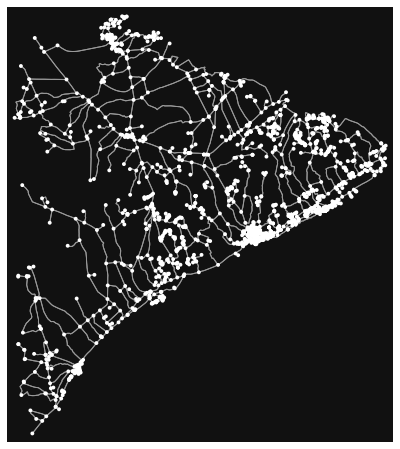

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fba2a902d30>)

In [32]:
# 20km radius
test = nx.generators.ego_graph(G, sample_nodes[300], radius=20000, distance="length")
ox.plot_graph(test)

In [53]:
nodes, edges = ox.graph_to_gdfs(test)
nodes = nodes.replace({"True": True, "False": False})

actual_stops_present = set(actual_stops["osmid"]).intersection(nodes["osmid"])
gen_stops_present = set(generated_stops["osmid"]).intersection(nodes["osmid"])

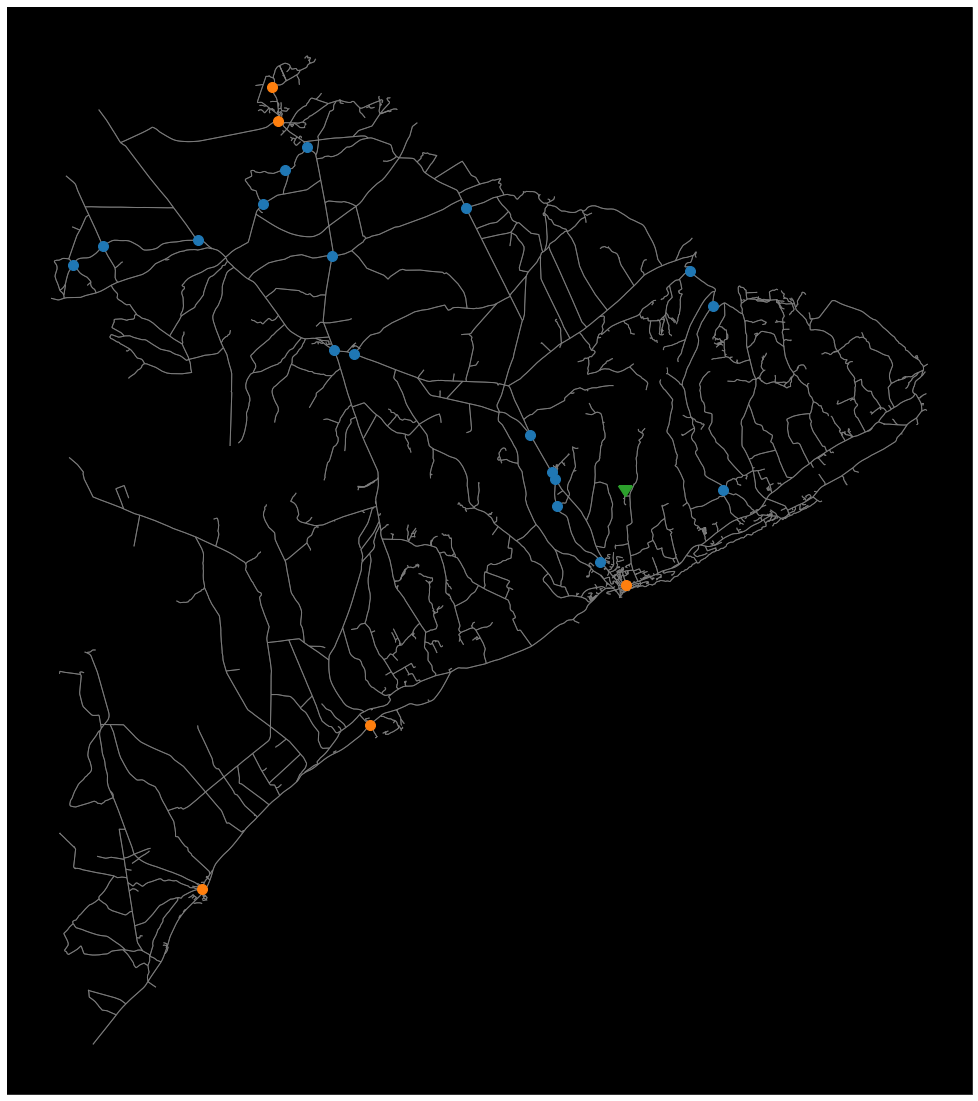

In [54]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

sample_node = nodes[nodes["osmid"] == sample_nodes[300]]
gen_stops = nodes[nodes["community_route"] == True]
ll_stops = nodes[nodes["actual_stop"] == True]
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

gen_stops.plot(
    ax=ax,
    marker="o",
    markersize=100,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

ll_stops.plot(
    ax=ax,
    marker="o",
    markersize=100,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

sample_node.plot(
    ax=ax,
    marker=7,
    markersize=200,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

In [ ]:
##################
# analysis  - mean distance to a bus stop in either system
#           -